In [216]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy
import itertools

In [239]:
# read in csv DR 18 from sdss
df = pd.read_csv('sdss_mixed.csv')

In [240]:
# quality check look at size, first five rows, stats, and info
def check_quality(dataframe):
    print(f'SIZE:\n number of rows: {dataframe.shape[0]}\n number of cols:{dataframe.shape[1]}\n')
    print(f'INFO:\n {dataframe.info()}\n')
    print(f'COL STATS:\n {df.describe()}')

check_quality(df)

SIZE:
 number of rows: 150000
 number of cols:19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   u         150000 non-null  float64
 1   g         150000 non-null  float64
 2   r         150000 non-null  float64
 3   i         150000 non-null  float64
 4   z         150000 non-null  float64
 5   u-g       150000 non-null  float64
 6   g-r       150000 non-null  float64
 7   r-i       150000 non-null  float64
 8   i-z       150000 non-null  float64
 9   class     150000 non-null  object 
 10  subClass  135027 non-null  object 
 11  redshift  150000 non-null  float64
 12  mjd       150000 non-null  int64  
 13  clean     150000 non-null  int64  
 14  mode      150000 non-null  int64  
 15  zWarning  150000 non-null  int64  
 16  probPSF   150000 non-null  int64  
 17  ra        150000 non-null  float64
 18  dec       150000 non-null  float64

In [ ]:
'''
check how many observations exist where bandpass filters(u,g,i,z) equal to -9999.0 
look at how this changes the statistics 
get new shape of the dataframe
'''
# check if just observation is moving the min down for all bandpass filters
print(df[(df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0)])
print(df[~((df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0))].describe())
print(df[~((df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0))].shape)

                 u           g         r           i           z  \
4196      16.54159    14.55317  13.92500 -9999.00000    13.61874   
9957      19.85678    17.62529  16.70745 -9999.00000 -9999.00000   
9968   -9999.00000 -9999.00000  18.37470    18.17690 -9999.00000   
11114  -9999.00000    18.25937  17.76823    17.57264    17.47415   
38396     22.84665 -9999.00000  18.84487    18.24343 -9999.00000   
48401  -9999.00000 -9999.00000  18.48849 -9999.00000 -9999.00000   
48671  -9999.00000 -9999.00000  19.47683 -9999.00000 -9999.00000   
48693     19.44848    20.14834  18.06796 -9999.00000 -9999.00000   
49501  -9999.00000 -9999.00000  17.11245 -9999.00000 -9999.00000   
70494     19.77192 -9999.00000  17.81463 -9999.00000 -9999.00000   
104194 -9999.00000 -9999.00000  18.73432    18.53705    18.63315   
109749 -9999.00000 -9999.00000  19.99271    19.82447    19.46729   
120912    20.55781 -9999.00000  19.94032    20.01163    19.98301   

                 u-g           g-r           r-

In [ ]:
'''
only lost 13 observations where the bandpass filters are equal to -9999.0
looking at means and modes for each feature of our dataset they appear very close
let's look at a histogram for the following features:
bandpass filters(u,g,r,i,z)
color indices(u-g,g-r,r-i,i-z)
redshift

not interested in looking at zWarning, probPSF, clean, and mode
because these are just binary classifiers

not interested in looking at right ascension or declination since this is just a position
on the celestial sphere.. think how we use latitude and longitude on earth

not interested in looking at distribution of class or subClass since these are 
categorical variables

mjd(modified julian date) can be both categorical or numeric depending on our analysis.
dig into this later..
'''

# create a list of numerical variables
num_vars = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z','redshift']
def num_vars_dist(df,num_vars,nplots_rows,nplots_cols):
    '''
    Input
    df: pd.dataframe -> pandas DataFrame containing data
    num_var: list -> list of column names found in the dataframe
    nplots_rows: int -> total rows for subplots
    nplots_cols: int -> total columns for subplots
    '''
    fig, ax = plt.subplots(nplots_rows,nplots_cols,figsize=(10, 8))
    fig.suptitle("NDataset Distribution: Numerical Variables",y=0.75)
    ax = ax.flatten()
    
    for i, num_var in enumerate(num_vars):
        sns.histplot(df[num_var],ax=ax[i]) 
        ax[i].set_title(num_var)
    
    fig.tight_layout()
    plt.show()

# create figure to visualize distribution for numerical variables
num_vars_dist(df,num_vars,2,5)

KeyboardInterrupt: 

In [ ]:

'''
30,000 points with 20 diff columns.
the following cols aren't useful.. just names for each event:
objid, run, rerun, fiberid,specobjid, camcol

the following cols aren't useful since we have ra and dec:
field

the following cols are not useful since all are the same:
mode: all are 1 and this means that all entries are primary events

remove where dered_u,dered_u,dered_g,dered_r,dered_i
'''
df = df.drop(['objid','mode','run','rerun','specobjid','camcol','field','fiberid'],axis=1)
df = df[df['dered_u'] > -9999]



In [230]:
# check what cols remain
print(df.head())
'''
from df.describe() probPSF something strange is going on for lower 25%
probPSF is a probability so we can drop neg values
lets look at what values exist using df.value_counts()
'''
print(df.probPSF.value_counts())

           ra        dec   dered_u   dered_g   dered_r   dered_i   dered_z  \
0  128.882533  54.928917  19.43687  17.76148  17.13218  16.91798  16.80427   
1  128.871464  54.967883  19.22869  18.08300  17.66953  17.49974  17.44089   
2    8.642699  -9.461544  20.47800  19.48022  19.40721  19.40105  19.31647   
3    9.035362  -9.373860  19.66633  18.18865  17.61381  17.40076  17.23395   
4    9.050701  -9.520176  18.82208  17.59743  17.15259  16.96230  16.86727   

  class  redshift  plate    mjd  probPSF  
0  STAR -0.000153   3362  54939        1  
1  STAR  0.000061   3362  54939        1  
2  STAR -0.000525   3105  54825        1  
3  STAR  0.000059   3105  54825        1  
4  STAR -0.000098   3105  54825        1  
probPSF
1    19059
0    10938
Name: count, dtype: int64


In [231]:
# drop negative values for probPSF
df = df[df['probPSF']>= 0]

In [232]:
# convert modified julian date to standard date
df['date'] = pd.to_datetime(df.mjd, unit='D', origin='1858-11-17')

# check what our years our data spans
print(f'the dataset spans {df.date.dt.year.max()-df.date.dt.year.min()} years from \
{df.date.dt.year.min()} to {df.date.dt.year.max()}')


the dataset spans 20 years from 2000 to 2020


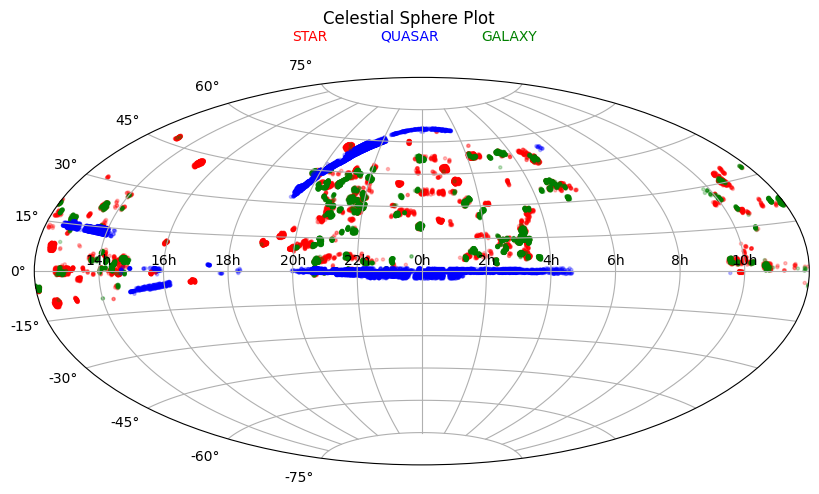

In [233]:
# we know temporal spread of data lets look at spacial distribution

def plot_celestial(ra_deg, dec_deg, obj_class):
    """Plots RA and Dec on an Aitoff projection."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)
    # Convert RA to -180 to 180 range for Aitoff projection 
    # 0 to 360 --> -180 to 180 by subtracting 180
    ra_deg = ra_deg-180

    # Convert RA to radians
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    # Create a dictionary to map classes to colors
    class_colors = {'STAR': 'red', 'QSO': 'blue', 'GALAXY': 'green'}
    colors = [class_colors[c] for c in obj_class]

    ax.scatter(ra_rad, dec_rad, s=5, alpha=0.25, color=colors)  # Single color for now

    # set title
    fig.text(0.5, 0.80, "Celestial Sphere Plot", ha="center", va="bottom", size="large")
    fig.text(0.4, 0.78, "STAR", ha="center", va="bottom", size="medium",color="red")
    fig.text(0.5, 0.78, "QUASAR", ha="center", va="bottom", size="medium",color='blue')
    fig.text(0.6,0.78,"GALAXY", ha="center", va="bottom", size="medium",color="green")

    # Set tick labels for RA (optional)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
    
    plt.show()
plot_celestial(df.ra, df.dec, df['class'])

In [179]:
from IPython.display import display
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29998 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ra        29998 non-null  float64       
 1   dec       29998 non-null  float64       
 2   dered_u   29998 non-null  float64       
 3   dered_g   29998 non-null  float64       
 4   dered_r   29998 non-null  float64       
 5   dered_i   29998 non-null  float64       
 6   dered_z   29998 non-null  float64       
 7   class     29998 non-null  object        
 8   redshift  29998 non-null  float64       
 9   plate     29998 non-null  int64         
 10  mjd       29998 non-null  int64         
 11  probPSF   29998 non-null  int64         
 12  date      29998 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 3.2+ MB


None

In [234]:
'''
we can use redshift to calc distance for each object using the equation below:
redshift=z
speed of light = c ~ 3.0 E 5 km/s
hubble const = H0 ~ 70 km/s per Mpc
note pc is parsecs 
velocity of obj(star, galaxy, quasar~QSO)
1. we need redshift !=0 to calc velocity so drop where redshift is 0
note: this is because we are calc distance based on Hubble's law because 
of the features that are available to us
note: this drops around ~ 8000 observations
2. take absolute value of z since sign indicates direction
note: neg red shift just means obj is moving towards us so we will take 
absolute value
2. solve for v of obj
- use: v = c*((1 + z)² - 1) / ((1 + z)² + 1))
note: account for relativistic effects as this wont hurt observations 
z<<1
3.
note: neg red shift just means obj is moving towards us so we will take 
absolute value
note: one parsec is ~ 3.26 light years or ~3E13 km
''' 
# create new df where redshift != 0
df_distance = df[df['redshift']!=0].copy()
def calc_redshift_distance(z):
    # define hubble const(H0) and speed of light c
    H0 = 70 * astropy.units.km/astropy.units.s/astropy.units.Mpc
    c = astropy.constants.c.to('km/s')
    # take absolute value of z
    z_abs = abs(z)
    # solve for velocity
    v = c*(((1 + z_abs)**2 - 1) / ((1 + z_abs)**2 + 1))
    # solve for distance unit Mpc or 1 million parsecs
    d = v/H0
    return(d)

# add new col dist to distance dataframe units are in Mpc
df_distance.loc[:,'dist'] = df_distance['redshift'].apply(calc_redshift_distance)


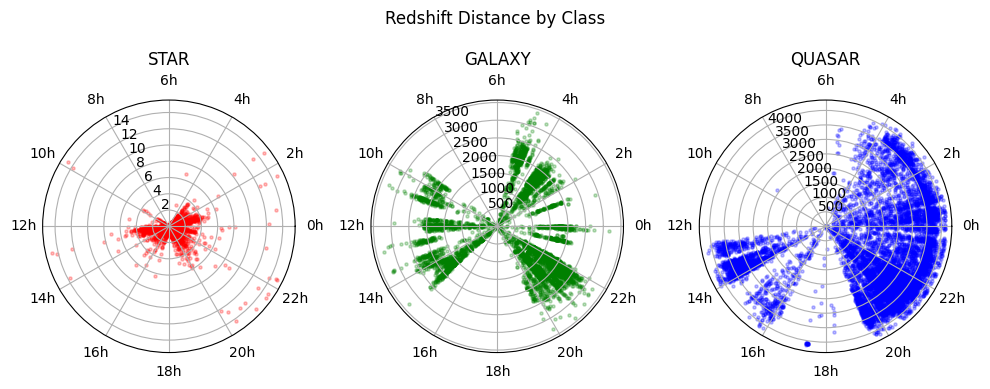

In [235]:
# now that we ave distance let's look that how each type is distributed
def redshift_dist(df):
    fig, ax = plt.subplots(1,3,figsize=(10, 8),subplot_kw={'projection': 'polar'})
    fig.suptitle("Redshift Distance by Class",y=0.75)
    ax = ax.flatten()
    class_colors = {'STAR': 'red', 'QSO': 'blue', 'GALAXY': 'green'}
    
    for i, obj_type in enumerate(df['class'].unique()):
        dist = df_distance[df_distance['class']==obj_type]['dist']
        dist_scaler = np.array([Mpc.value for Mpc in dist])
        ra_deg = df_distance[df_distance['class']==obj_type]['ra']-180
        ra_rad = np.radians(ra_deg)
        ax[i].scatter(ra_rad, dist_scaler, s=5, alpha=0.25, color=class_colors[obj_type]) 
        if obj_type == 'QSO':
            ax[i].set_title("QUASAR")
        else:
            ax[i].set_title(f"{obj_type}")
        ax[i].set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))  # Divide into 12
        ax[i].set_xticklabels(['0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'])
        ax[i].set_rlabel_position(120)
        ax[i].grid(True)
    
    fig.tight_layout()
    plt.show()

redshift_dist(df_distance)

ra                   203.425263
dec                   -0.263572
dered_u                23.51317
dered_g                21.97775
dered_r                22.03197
dered_i                21.91879
dered_z                21.37803
class                       QSO
redshift               2.218933
plate                      4046
mjd                       55605
probPSF                       1
date        2011-02-13 00:00:00
Name: 26704, dtype: object


/tmp/ipykernel_300430/499332753.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


"\nprint(df[df['probPSF']==0]['redshift'].value_counts())\nprint(df_distance[df_distance['class']=='STAR']['dered_g'].describe())\nprint(df_distance[df_distance['class']=='QSO']['dist'].describe())\nprint(df_distance[df_distance['class']=='GALAXY']['dist'].describe())'\n"

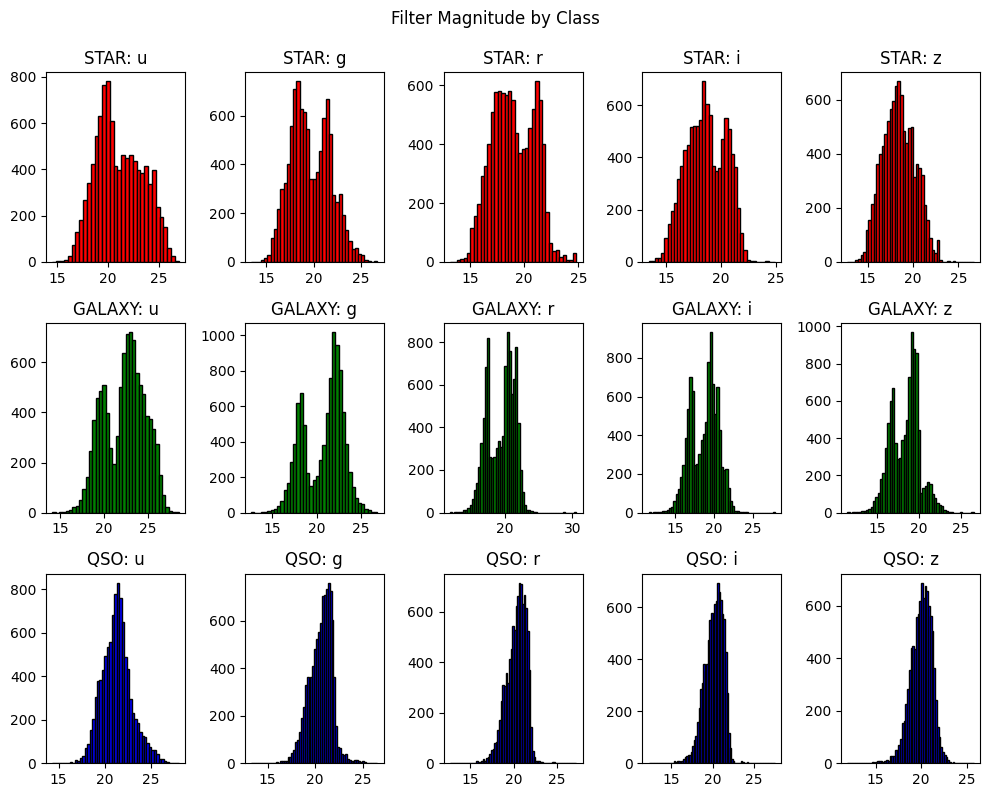

In [ ]:
'''
look at the magnitude distribution for each photometric bands for star, galaxy, and qso(quasar)
note: dered_filter means that the magnitudes have had error removed from them
FILTER WAVELENGTHS(nm)
u (ultraviolet):   355.652
g (green):         470.250
r (red):           617.558
i (near-infrared): 748.998
z (infrared):      894.671
'''

df_mag = df.loc[:,['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'class']]
def calc_bins(drange,samples,stdev):
  '''
  calc optimal number of histogram bins based on Scott 1979
  https://academic.oup.com/biomet/article-abstract/66/3/605/232642
  bins =R(n^(1/3))/(3.49σ)
  R: range of data
  n: sample size
  σ: standard deviation of data
  '''
  bins = drange*(samples**(1/3))/(3.49*stdev)
  return(int(bins))
def mag_dist_by_class(df):
  # define mags
  mags =  ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']
  obj_type = list(df['class'].unique())
  obj_mag = list(itertools.product(obj_type,mags))
  class_colors = {'STAR': 'red', 'QSO': 'blue', 'GALAXY': 'green'}
  fig, ax = plt.subplots(3,5,figsize=(10, 8))
  fig.suptitle("Filter Magnitude by Class",y=0.99)
  ax = ax.flatten()

  for i, type_mag in enumerate(obj_mag):
    #('STAR', 'dered_u'), ('STAR', 'dered_g')
    plot_data = df[df['class']==type_mag[0]][type_mag[1]]
    nbins = calc_bins(plot_data.max()-plot_data.min(), plot_data.shape[0],plot_data.std())
    ax[i].hist(plot_data, bins=nbins, color=class_colors[type_mag[0]], edgecolor='black')
    ax[i].set_title(f'{type_mag[0]}: {type_mag[1].split('_')[-1]}')    
    
  fig.tight_layout()
  fig.show()

mag_dist_by_class(df) 

'''
print(df[df['probPSF']==0]['redshift'].value_counts())
print(df_distance[df_distance['class']=='STAR']['dered_g'].describe())
print(df_distance[df_distance['class']=='QSO']['dist'].describe())
print(df_distance[df_distance['class']=='GALAXY']['dist'].describe())'
'''

/tmp/ipykernel_300430/499332753.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


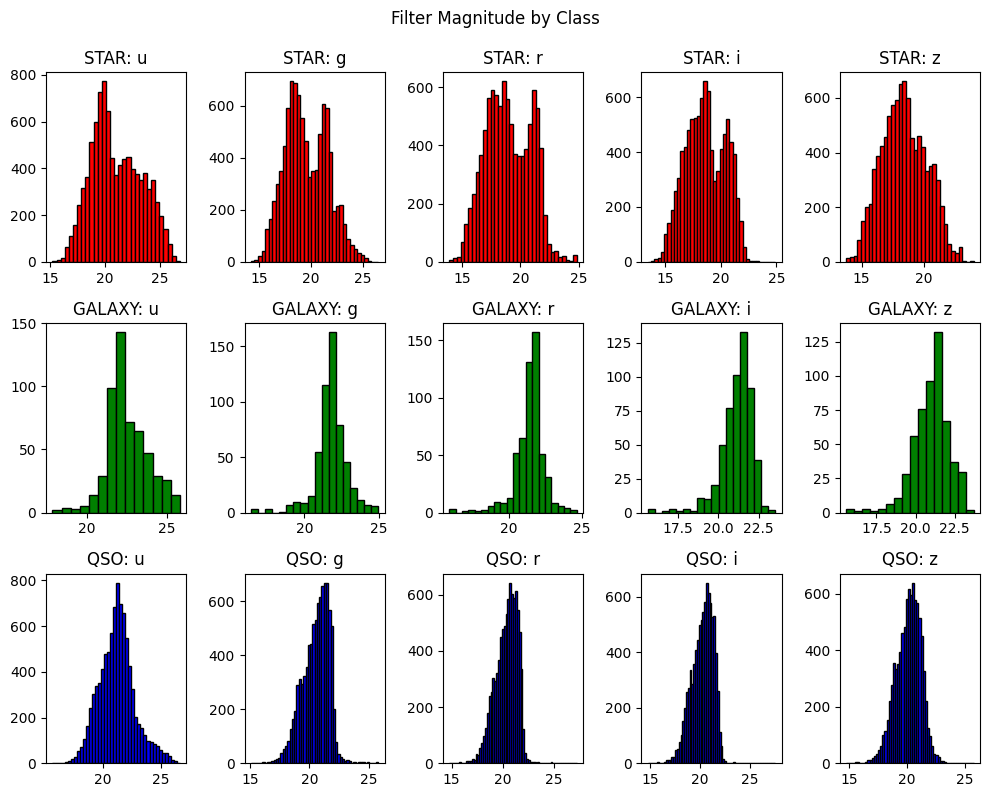

In [238]:
'''
print(df[df['probPSF']==0]['redshift'].value_counts())
print(df_distance[df_distance['class']=='STAR']['dered_g'].describe())
print(df_distance[df_distance['class']=='QSO']['dist'].describe())
print(df_distance[df_distance['class']=='GALAXY']['dist'].describe())'
'''
df2 = df[df['probPSF']==1]
mag_dist_by_class(df2)
